### features:
* selected spectogram coef
* zero crossing rate
* selected chromogram values
* selected tempogram values
* wavelet of level 0

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
import itertools

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
csv_path = "/Users/ecem/Desktop/csv of scgs"
wavelet_csv = "/Users/ecem/Desktop/wavelet-csv"

## Load data

Here, our target is to predict disease correctly. So; our y will be disease column of  dataset

In [3]:
spec = pd.read_csv(csv_path + '/p-value-selected-intersection-spec.csv', index_col = 0)
#spec  #uncomment to see dataframe

signal_proc = pd.read_csv(csv_path + '/signal_processing.csv', index_col = 0)
y = signal_proc.disease

zero_crossing = signal_proc.iloc[:,:21]
#zero_crossing #uncomment to see dataframe

tempogram = pd.read_csv(csv_path + '/p-value-selected-tempogram-union.csv', index_col = 0)
#tempogram #uncomment to see dataframe

chromogram = pd.read_csv(csv_path + '/p-value-selected-union-chromogram.csv', index_col = 0)
#chromogram #uncomment to see dataframe

w_lvl0 = pd.read_csv(csv_path+ '/wavelet_lvl0.csv', index_col = 0).drop(['disease'], axis =1)
#w_lvl0  #uncomment to see dataframe

#wavelet  = pd.read_csv(csv_path + '/p-value-selected-mean-wavelet.csv', index_col = 0)

In [4]:
y

0       MR
1       MR
2       MR
3       MR
4       MR
        ..
1455    AS
1456    AS
1457    AS
1458    AS
1459    AS
Name: disease, Length: 1460, dtype: object

In [7]:
features = pd.concat([spec, w_lvl0], axis = 1)
features = pd.concat([features, zero_crossing], axis = 1)
features = pd.concat([features, chromogram], axis = 1)
features = pd.concat([features, tempogram], axis = 1)
#features = pd.concat([features, wavelet], axis = 1)


features

,freq_y1772,freq_z1773,freq_y1774,freq_z1774,freq_x555,freq_y555,freq_z555,freq_x556,freq_y556,freq_z556,...,tempogram_z106,tempogram_y112,tempogram_x116,tempogram_y207.1,tempogram_y227.1,tempogram_z246,tempogram_z253,tempogram_y353,tempogram_y370,tempogram_z374.1
0,0.001532,0.001638,0.001677,0.001672,0.001892,0.001941,0.002010,0.002093,0.002200,0.002322,...,4.494106e-17,2.962999e-17,6.733245e-17,-2.724992e-17,1.186894e-17,4.947992e-17,3.143395e-17,-2.013831e-17,-2.173347e-17,5.255093e-17
1,0.001083,0.001132,0.001141,0.001149,0.001957,0.001952,0.001978,0.002046,0.002179,0.002357,...,2.742302e-17,4.300870e-17,4.590532e-17,-1.337395e-17,1.154142e-17,-5.012637e-20,3.352991e-17,-1.643196e-17,-3.131140e-17,4.355038e-17
2,0.000997,0.001008,0.001048,0.001075,0.001647,0.001770,0.001908,0.002053,0.002199,0.002335,...,5.695394e-17,5.434512e-17,4.959943e-17,2.657111e-18,2.726203e-17,2.511922e-17,2.399343e-17,-9.669493e-18,-4.787120e-17,7.317623e-17
3,0.001562,0.001503,0.001520,0.001516,0.001810,0.001874,0.001938,0.002015,0.002086,0.002144,...,4.002449e-17,3.704987e-17,5.075071e-17,-3.994002e-17,2.930543e-17,2.386421e-17,3.700749e-17,-1.438568e-17,-2.220229e-17,8.881837e-17
4,0.001470,0.001204,0.001127,0.001114,0.002247,0.002255,0.002247,0.002222,0.002186,0.002146,...,5.836358e-17,6.028812e-17,7.356340e-17,-1.411388e-17,1.736420e-17,1.512212e-17,3.730192e-17,-2.694114e-17,-7.030712e-17,2.926575e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.001078,0.001225,0.001262,0.001274,0.002092,0.001987,0.001902,0.001843,0.001815,0.001815,...,3.274181e-17,4.080143e-17,3.002664e-17,1.322290e-17,3.625893e-17,1.105587e-17,2.601346e-17,-3.514779e-19,-2.330293e-17,7.273644e-17
1456,0.001541,0.001603,0.001553,0.001534,0.001942,0.001951,0.001939,0.001905,0.001852,0.001789,...,4.402990e-17,4.736565e-17,4.041930e-17,3.118530e-19,3.561906e-17,4.093931e-17,4.207797e-17,8.008623e-18,-3.206030e-17,9.019197e-17
1457,0.001214,0.001122,0.001129,0.001130,0.002109,0.002055,0.002006,0.001959,0.001909,0.001862,...,6.571730e-17,7.123703e-17,7.050584e-17,-2.603978e-17,1.424453e-17,2.042900e-17,4.225717e-17,5.550884e-18,-5.380471e-17,7.213398e-17
1458,0.001335,0.001130,0.001096,0.001092,0.002863,0.002948,0.003014,0.003062,0.003079,0.003065,...,3.243106e-17,5.146443e-17,3.075446e-17,-3.008675e-17,1.116627e-17,-3.201455e-18,4.965608e-18,5.104215e-18,-4.635523e-17,8.280988e-17


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([2, 2, 2, ..., 1, 1, 1])

In [9]:
list(le.classes_)

['AR', 'AS', 'MR', 'MS']

In [10]:
#sanity check
le.inverse_transform([0,1,2,3])

array(['AR', 'AS', 'MR', 'MS'], dtype=object)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(features, y_encoded, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [12]:
import xgboost as xgb
model  = xgb.XGBClassifier(random_state = 42, objective='multi:softprob', eval_metric = 'merror') 

# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [13]:
predictions = model.predict(X_valid)

In [14]:
classes = ['AR', 'AS', 'MR', 'MS']

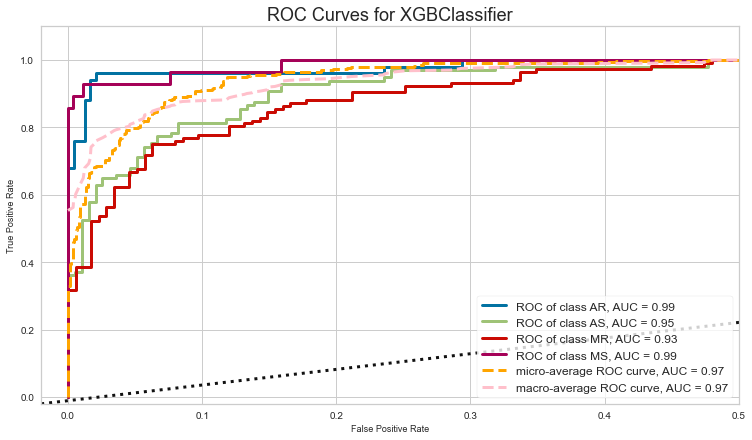

In [15]:
rocauc = ROCAUC(model, size=(900, 500), classes=classes )

rocauc.fit(X_train, y_train)       
rocauc.score(X_valid, y_valid)  
r = rocauc.poof()

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


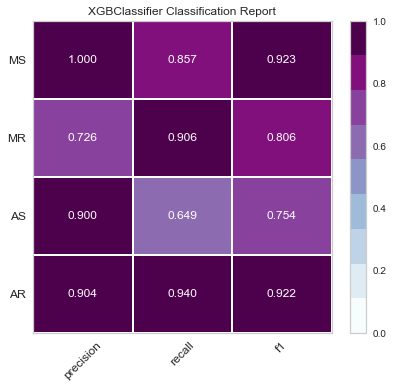

In [16]:
report = ClassificationReport(model, size=(425, 400), classes=classes, cmap = 'BuPu' )

report.score(X_valid, y_valid)
c = report.poof()

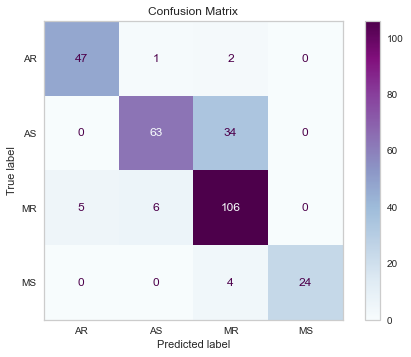

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
conf =  ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid, display_labels= ['AR', 'AS', 'MR', 'MS'], cmap = 'BuPu') 
conf.ax_.set_title("Confusion Matrix")
plt.grid(None)
plt.show()

In [18]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid, predictions)
print("accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y_valid, predictions, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y_valid, predictions, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

accuracy: 82.19%
recall: 82.19%
precision: 84.05%


### with 0.0001 variation

In [19]:
vt = VarianceThreshold(threshold = 0.0001)
_ = vt.fit(features)
masked = vt.get_support()
features_masked = features.loc[:, masked]
features_masked # uncomment to see the dataframe

,freq_z1926,freq_x1927,freq_y1939,freq_z1939,freq_y1927,freq_z1927,freq_x563,freq_y563,freq_z563,freq_x564,...,A_x.1,A_y,A_z,A♯_y,A♯_z,B_x,B_y,B_z,tempogram_y256,tempogram_z256
0,0.002495,0.002421,0.004540,0.004613,0.002364,0.002332,0.001880,0.001847,0.001862,0.001916,...,0.550876,0.488099,0.473361,0.718695,0.840319,0.977623,1.000000,1.000000,0.450049,0.399489
1,0.002897,0.002714,0.004404,0.004651,0.002611,0.002599,0.002337,0.002379,0.002457,0.002556,...,0.616335,0.558207,0.525845,0.776684,0.942876,1.000000,0.981521,0.967486,0.378557,0.379534
2,0.002412,0.002362,0.005214,0.005539,0.002325,0.002314,0.002527,0.002576,0.002617,0.002632,...,0.528083,0.472831,0.417259,0.660383,0.915534,0.982367,0.969857,1.000000,0.527338,0.529886
3,0.002437,0.002573,0.005090,0.005287,0.002720,0.002851,0.002739,0.002798,0.002831,0.002832,...,0.514232,0.449276,0.471934,0.709124,0.834021,0.982914,0.909575,1.000000,0.468522,0.451061
4,0.002391,0.002287,0.004504,0.004483,0.002203,0.002140,0.002171,0.002146,0.002130,0.002137,...,0.412994,0.469447,0.453689,0.759921,0.824143,0.964620,0.875552,0.993204,0.482974,0.477975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.002783,0.002692,0.003435,0.003656,0.002633,0.002606,0.001596,0.001581,0.001591,0.001644,...,0.701580,0.647582,0.687628,0.928917,0.952990,0.919111,1.000000,0.933530,0.478830,0.441118
1456,0.003113,0.003086,0.004489,0.004401,0.003046,0.002986,0.001616,0.001638,0.001668,0.001709,...,0.697578,0.694199,0.780676,0.854429,0.922914,0.962602,0.932648,0.914875,0.603069,0.587210
1457,0.003209,0.003099,0.004050,0.004191,0.003002,0.002913,0.001755,0.001818,0.001871,0.001920,...,0.676887,0.637471,0.764013,0.899584,1.000000,0.998977,0.993931,0.902801,0.542725,0.547244
1458,0.003424,0.003496,0.003284,0.003202,0.003575,0.003669,0.002414,0.002426,0.002417,0.002395,...,0.827662,0.807564,0.778463,0.777422,0.859151,0.910143,1.000000,0.987707,0.657887,0.667110


In [20]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features_masked, y_encoded, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [21]:
import xgboost as xgb
model_  = xgb.XGBClassifier(random_state = 42, eval_metric = 'merror', objective='multi:softprob' ) 

# Fit the model
model_.fit(X_train_, y_train_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [21]:
predictions_ = model_.predict(X_valid_)

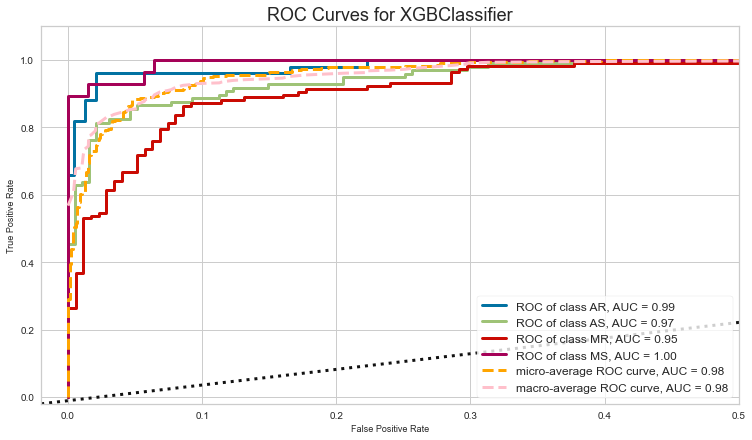

In [22]:
rocauc_ = ROCAUC(model_, size=(900, 500), classes=classes)

rocauc_.fit(X_train_, y_train_)       
rocauc_.score(X_valid_, y_valid_)  
r = rocauc_.poof()

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


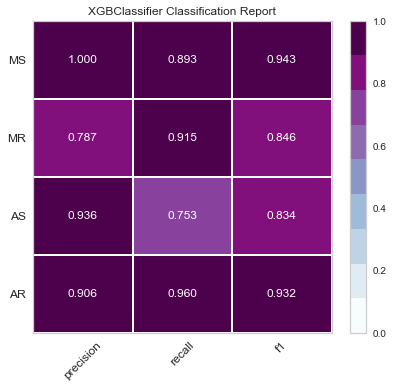

In [23]:
c

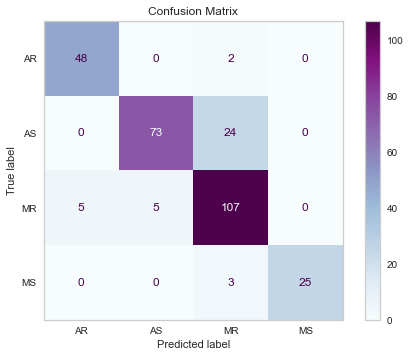

In [24]:
conf_ =  ConfusionMatrixDisplay.from_estimator(model_, X_valid_, y_valid_, display_labels= ['AR', 'AS', 'MR', 'MS'], cmap = 'BuPu')   
conf_.ax_.set_title("Confusion Matrix")
plt.grid(None)
plt.show()

In [25]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid_, predictions_)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.64%


In [26]:
recall = recall_score(y_valid_, predictions_, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y_valid_, predictions_, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

recall: 86.64%
precision: 87.71%
